# 6.backbone analysis

## Packages

In [1]:
import os
import sys

import numpy as np
import gseapy as gp
from scipy.spatial import KDTree
import dynamo as dyn
import spateo as st

/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/yao/.local/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning:

The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and poin

## Data source

In [3]:
# embryo anndata
embryo_adata = st.sample_data.drosophila(filename="E7-9h_cellbin_tdr_v2.h5ad")

# embryo mesh model
# The embryo mesh model are reconstructed by ``2.three dims models reconstruction``
embryo_mesh = st.tdr.read_model(filename=f"embryo_mesh_model.vtk")

# tissue
# The tissue pc model and mesh model are reconstructed by ``3.three dims models reconstruction of subpopulations`` using ``E7-9h_cellbin_tdr_v2.h5ad``
tissue_pc = st.tdr.read_model(filename=f"subpopulatio_pc_model.vtk")
tissue_mesh = st.tdr.read_model(filename=f"subpopulatio_mesh_model.vtk")
tissue_adata = embryo_adata[tissue_pc.point_data["obs_index"].tolist(), :].copy()
tissue_adata.X = tissue_adata.layers["counts_X"]
tissue_adata.layers["log1p_X"] = np.log1p(tissue_adata.layers["counts_X"])
tissue_adata.uns["pp"] = {}
dyn.pp.normalize_cell_expr_by_size_factors(adata=tissue_adata, layers="X", X_total_layers=True,  skip_log=True)

# cpo
cpo = [(553.2878243418567, 1098.4674808068507, 277.4399476053088),
 (1.9670869138005287, -6.902875264241757, -2.2120172004343885),
 (-0.16299443079060863, -0.16480753930466982, 0.9727647662819544)]

|-----> rounding expression data of layer: X during size factor calculation
|-----> size factor normalize following layers: ['X']
|-----? `total_szfactor` is not `None` and it is not in adata object.
|-----> skipping log transformation as input requires...
|-----> applying None to layer<X>
|-----> set adata <X> to normalized data.
|-----> <insert> pp.norm_method to uns in AnnData Object.


## 3D reconstruction of tissue's backbonne

Due to experimental reasons, some data are missing from the tissue. Therefore, some data are artificially added to complete the tissue.

In [4]:
add_region = st.tdr.interactive_rectangle_clip(model=tissue_pc.copy(), key="tissue")
add_region = st.tdr.merge_models(add_region)

adjust_tissue_pc = [tissue_pc.copy()]
for x_dist in range(2, 22, 2):
    for z_dist in range(2, 12, 2):
        add_pc = add_region.copy()
        add_pc.points[:, 0] = add_pc.points[:, 0] - x_dist
        add_pc.points[:, 2] = add_pc.points[:, 2] - z_dist
        adjust_tissue_pc.append(add_pc)

used_tissue_pc = st.tdr.merge_models(models=adjust_tissue_pc)

In [10]:
_, tissue_backbone, tissue_backbone_length = st.tdr.changes_along_branch(
    model=used_tissue_pc,
    rd_method="PrinCurve",
    NumNodes=30,
    epochs=300,
    scale_factor=10,
    inplace=True,
    color="orangered"
)

backbone_nodes = np.asarray(tissue_backbone.points)
backbone_nodes_kdtree = KDTree(np.asarray(backbone_nodes))
_, ii = backbone_nodes_kdtree.query(np.asarray(tissue_adata.obsm["3d_align_spatial"]), k=1)
tissue_adata.obs["tissue_backbone"] = ii

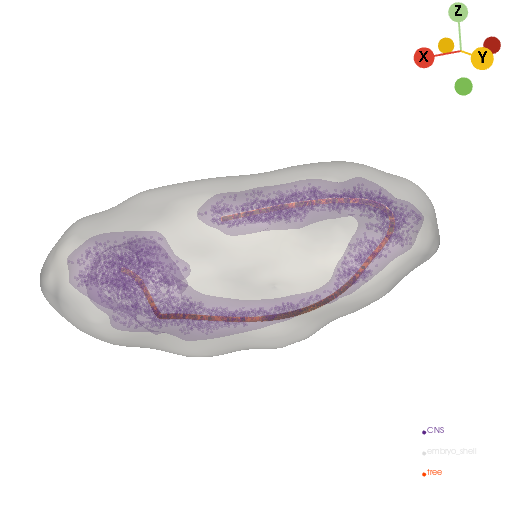

In [11]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([embryo_mesh, tissue_mesh, tissue_pc, tissue_backbone]),
    key=["tissue", "tissue", "tissue", "tree"],
    opacity=[1, 0.2, 0.3, 1],
    model_style=["surface", "surface", "points", "wireframe"],
    model_size=[0, 0, 3, 5],
    show_legend=True,
    off_screen=False,
    jupyter="static",
    cpo=cpo,
    window_size=(512, 512),
)

## Differential genes expression tests using generalized linear regressions

In [12]:
st.tl.glm_degs(
    adata=tissue_adata,
    fullModelFormulaStr=f'~cr(tissue_backbone, df=3)',
    key_added="glm_degs",
    qval_threshold=0.01,
    llf_threshold=-2500
)

tissue_adata.uns["glm_degs"]["glm_result"]

|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.
|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [674.8105s]


,status,family,log-likelihood,pval,qval
hth,ok,NB2,-3024.336914,4.318592e-29,2.702774e-26
dap,ok,NB2,-4241.312012,8.517937e-22,3.465097e-19
Ama,ok,NB2,-2691.844727,3.989105e-18,1.329552e-15
rhea,ok,NB2,-2849.047363,5.076354e-18,1.529675e-15
lncRNA:CR45388,ok,NB2,-3122.158447,5.932173e-15,1.072537e-12
...,...,...,...,...,...
CG2852,ok,NB2,-4440.330566,2.029823e-03,8.311343e-03
ed,ok,NB2,-2568.484619,2.074525e-03,8.449698e-03
RpL34a,ok,NB2,-4970.446289,2.129064e-03,8.617942e-03
dnk,ok,NB2,-2508.686523,2.192309e-03,8.812563e-03


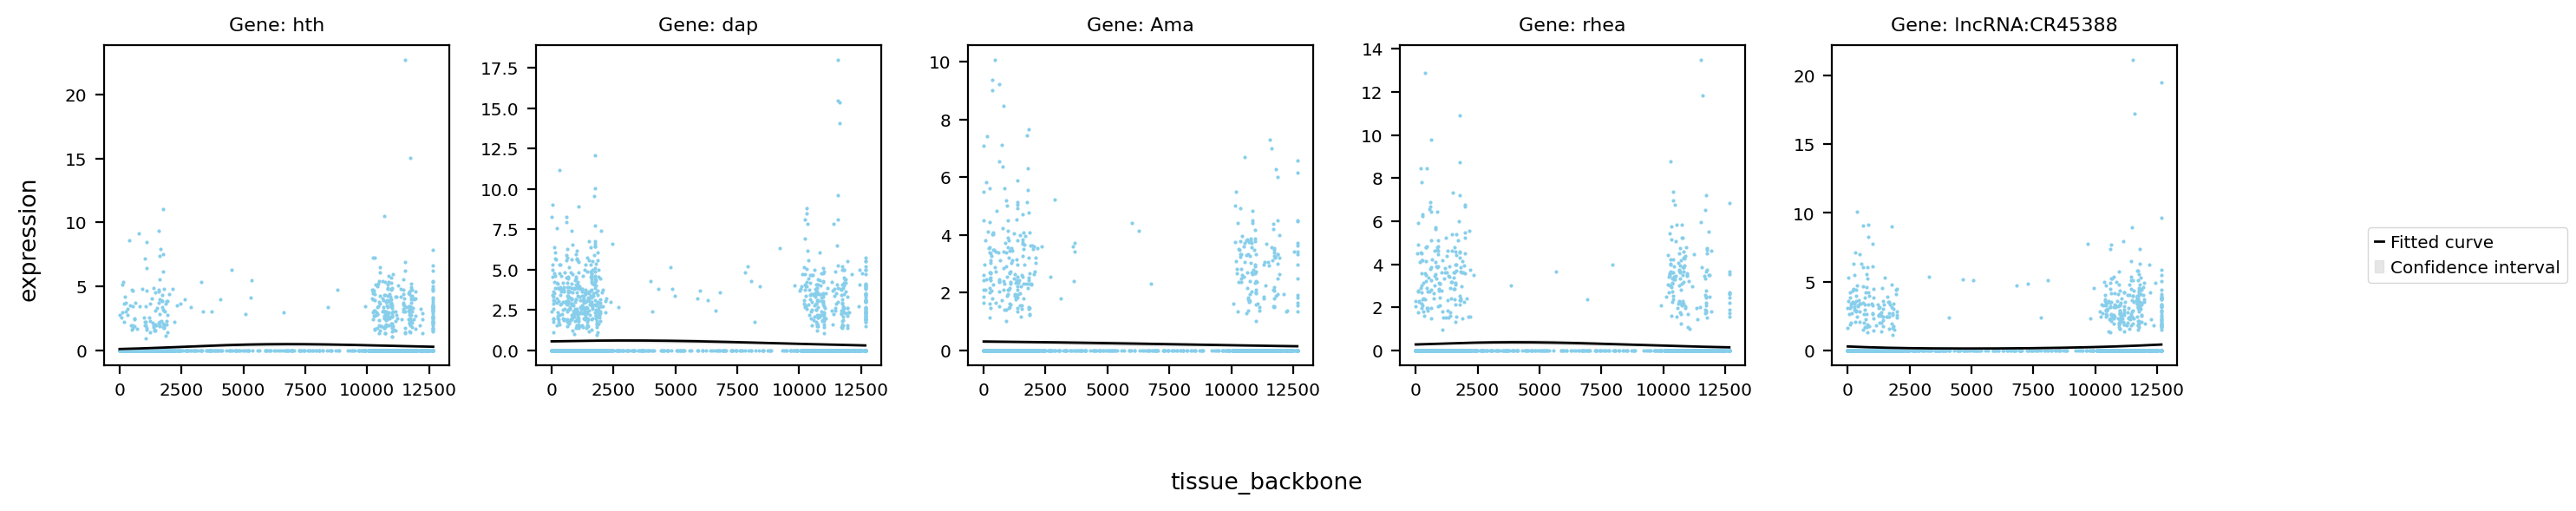

In [14]:
tissue_glm_data = tissue_adata.uns["glm_degs"]["glm_result"]
st.pl.glm_fit(
    adata=tissue_adata,
    gene=tissue_glm_data.index.tolist()[:5],
    ncols=5,
    feature_x="tissue_backbone",
    feature_y="expression",
    feature_fit="mu",
    glm_key="glm_degs",
    lowess=False,
    frac=0.2,
    save_show_or_return="show",
)

## GO enrichment based on enrichr

In [15]:
gp.get_library_name(organism="fly")

['Allele_LoF_Phenotypes_from_FlyBase_2017',
 'Allele_Phenotypes_from_FlyBase_2017',
 'Anatomy_AutoRIF',
 'Anatomy_AutoRIF_Predicted_zscore',
 'Anatomy_GeneRIF',
 'Anatomy_GeneRIF_Predicted_zscore',
 'Coexpression_Predicted_GO_Biological_Process_2018',
 'Coexpression_Predicted_GO_Cellular_Component_2018',
 'Coexpression_Predicted_GO_Molecular_Function_2018',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_GeneRIF',
 'GO_Biological_Process_GeneRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_GeneRIF',
 'GO_Cellular_Component_GeneRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF',
 'GO_Molecular_Function_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_GeneRIF',
 'GO_Molecular_Function_GeneRIF_Predicted_zscore',
 'Human_Disease_from_FlyBase_2017',
 

In [ ]:
# GO-biological process
go_bp = gp.enrichr(
    gene_list=tissue_glm_data.index.tolist(),
    gene_sets="GO_Biological_Process_2018",
    organism="fly",
    outdir="go_bp_result",
    no_plot=True,
    verbose=True
)

tissue_go_bp_results = go_bp.results
gp.barplot(
    tissue_go_bp_results,
    column='Combined Score',
    title='GO_Biological_Process',
    cutoff=0.05,
    top_term=100,
    figsize=(10, 25),
    ofname="go_barplot.pdf"
)
gp.dotplot(
    tissue_go_bp_results,
    column='Combined Score',
    title='GO_Biological_Process',
    cmap='viridis_r',
    cutoff=0.05,
    top_term=100,
    figsize=(10, 25),
    ofname="go_dotplot.pdf"
)